In [11]:
from math import sin, cos, acos, radians, degrees, sqrt, tan
import numpy as np
import pandas as pd
import numpy.linalg as linalg
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
%matplotlib inline

In [34]:
# pitcher to catcher distance ft
PITCHER_CATCHER_DISTANCE=58.75

# height of camera in ft
H=5.

# field of view in degrees
FOVx=63.54
FOVy=44.95886879
PIC_LENGTH=3264.
PIC_HEIGHT=2448.

In [35]:
def simple_x(x, y, pitcher_catcher_distance=60.5):
    pitchers_plate=x
    home_plate=y
    
    p_c_meters = pitcher_catcher_distance*0.3048
    X_pixels = pitchers_plate[0] - home_plate[0]

    X_proportion = abs(X_pixels / PIC_LENGTH)
    X_angle = radians(X_proportion*FOVx)
    print tan(X_angle)
    distance_meters = p_c_meters / tan(X_angle)

    distance_ft = distance_meters*(1/0.3048)
    return distance_ft

def more_complex(X_pixels , y_pixels, pitcher_catcher_distance=60.5, s=0, h=0):
    """ s is number of feet in front of pitchers plate the camera is"""
    #pitchers_plate=x
    #home_plate=y

    #p_c_meters = pitcher_catcher_distance*0.3048
    #s_meters = s*0.3048
    #X_pixels = pitchers_plate[0] - home_plate[0]
    #y_pixels = pitchers_plate[1] - home_plate[1]
    X_proportion = abs(X_pixels / PIC_LENGTH)
    y_proportion = abs(y_pixels / PIC_HEIGHT)
    X_angle_degrees = X_proportion*FOVx
    X_angle_degrees_front = X_angle_degrees * (pitcher_catcher_distance - s) / pitcher_catcher_distance
    X_angle_radians_front = radians(X_angle_degrees_front)
    y_angle = radians(y_proportion*FOVy)
    distance_ft = (pitcher_catcher_distance-s) / tan(X_angle_radians_front)

    #distance_ft = distance_meters*(1/0.3048)

    # correct for h
    d = sqrt(distance_ft**2 - h**2)    
    
    return d

def panorama(x, y, pitcher_catcher_distance=60.5, s=0):
    #pitchers_plate=x
    #home_plate=y
    
    pano_degrees_per_pixel = FOVx/PIC_LENGTH    
    
    p_c_meters = pitcher_catcher_distance*0.3048
    s_meters = s*0.3048
    X_pixels = x
    y_pixels = y
    X_angle_degrees = X_pixels*pano_degrees_per_pixel
    X_angle_degrees_front = X_angle_degrees * (pitcher_catcher_distance - s) / pitcher_catcher_distance
    X_angle_radians_front = radians(X_angle_degrees_front)
    y_proportion = abs(y_pixels / PIC_LENGTH)
    y_angle = radians(y_proportion*FOVy)
    distance_meters = (p_c_meters-s_meters) / tan(X_angle_radians_front)

    distance_ft = distance_meters*(1/0.3048)
    return distance_ft
        
def find_dist(X_pixels, y_pixels, pitcher_catcher_distance=60.5, s=0., h=0.):
    #pitchers_plate=x
    #home_plate=y
    #X_pixels = abs(pitchers_plate[0] - home_plate[0])
    #y_pixels = pitchers_plate[1] - home_plate[1]
    if X_pixels > PIC_LENGTH:
        return panorama(X_pixels, y_pixels, pitcher_catcher_distance, s=s)
    elif X_pixels < PIC_LENGTH:
        return more_complex(X_pixels, y_pixels, pitcher_catcher_distance, s=s, h=h)
    else:
        raise ValueError
    
    

TEST

In [36]:
test_dat = pd.read_excel('/Users/brianritz/projects/findball/distance_calibration/photos_20160225/photo_info.xlsx')
test_dat['xdiff']= test_dat.xmax - test_dat.xmin
test_dat['logxdiff'] = np.log(test_dat.xdiff)
test_dat['ydiff'] = test_dat.apply(lambda x: (x.ymax - x.ymin) * (-1 + 2*int(x.direction[0:4]=="up")), axis=1)
test_dat['xmintimesxdiff'] = test_dat.xmin*test_dat.xdiff
test_dat['xmin**2'] = test_dat.xmin**2
test_dat['xmin**3'] = test_dat.xmin**3
test_dat['xmin**4'] = test_dat.xmin**4
test_dat['xmin**6'] = test_dat.xmin**6
test_dat['logxmin'] = np.log(test_dat.xmin)

In [37]:
#all_pred = []
#for row, ser in test_dat.iterrows():
#    p1 = (ser.xmin, ser.ymin)
#    p2 = (ser.xmax, ser.ymax)
#    x_diff = ser.xmax-ser.xmin
#    y_diff= ser.ymax-ser.ymin
#    pred = more_complex(x_diff, y_diff, pitcher_catcher_distance=PITCHER_CATCHER_DISTANCE, s=0, h=H)
#    all_pred.append(pred)
test_dat.loc[:,'predicted_dist'] = test_dat.apply(lambda x: more_complex(x.xdiff, x.ydiff, pitcher_catcher_distance=PITCHER_CATCHER_DISTANCE, s=0, h=H), axis=1)
#test_dat['predicted_dist'] = pd.Series(all_pred)
test_dat.loc[:,'xmintimesxdifftimespredicted'] = test_dat.xmintimesxdiff*test_dat.predicted_dist
test_dat.loc[:,'xmintimespredicted'] = test_dat.xmin*test_dat.predicted_dist
test_dat.loc[:,'xmintimespredicted**2'] = test_dat.xmintimespredicted**2
test_dat.loc[:,'xmintimespredicted**4'] = test_dat['xmintimespredicted**2']**2
test_dat.loc[:,'predicted_dist**2'] = test_dat.predicted_dist**2
test_dat.loc[:,'predicted_dist_log'] = np.log10(test_dat.predicted_dist)
test_dat['resid'] = test_dat.predicted_dist - test_dat.distance_ft

First, we tried predicting the distance straight from trigonometry--that showed a pattern in the residuals that suggested that we should model that prediction.

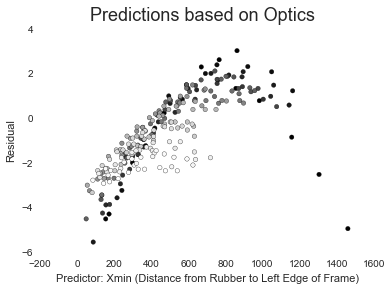

In [27]:
fig=plt.figure()
#fig2= plt.scatter(test_dat['xmintimesxdiff'], test_dat.resid, c=test_dat.distance_ft)
fig2= plt.scatter(test_dat['xmin'], test_dat.resid, c=test_dat.distance_ft)
fig2.axes.set_xlabel('Predictor: Xmin (Distance from Rubber to Left Edge of Frame)')
fig2.axes.set_ylabel('Residual')
fig.suptitle("Predictions based on Optics", fontsize=18)
#plt.scatter(test_dat['predicted_dist'], test_dat.resid)


In [28]:
import numpy as np
from sklearn.cross_validation import StratifiedShuffleSplit
test_dat = test_dat[test_dat['xmintimespredicted**4'] > 0]
X = test_dat.drop('distance_ft', axis=1)
y = test_dat.distance_ft

split = StratifiedShuffleSplit(y, n_iter=1, test_size=0.5, random_state=123)

for train_index, test_index in split:
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

('TRAIN:', array([ 93, 123,  66, 237,  52, 181, 221,  69, 220,   1,  18, 226, 161,
       149, 180, 208, 176,  90, 142,  44,  86, 118,  32,  88, 174, 129,
       104, 112,  76, 193,  91,  38, 239,  67,  71, 190,  56,  30, 170,
       114,  81, 201,  50, 232,  83, 172,  74,   2, 192, 141, 146, 195,
        59,  58,  19,  53, 207, 189, 150,  36, 203, 131,  27, 111,  39,
       211, 108, 148, 163, 140, 198, 100, 155,  28, 227, 162, 158, 101,
       224, 107,  96,  57, 230,   9, 151,  14, 119, 202, 191,  65,   5,
       135, 153, 171, 127,  46, 188,  34, 137, 238, 214,  21, 173,  79,
        22,   0, 164,  24,  98, 215, 116, 132,   4,  95, 225,  40,   6,  61]), 'TEST:', array([160, 130,  72,  51, 234, 217, 184, 138, 219, 212, 179, 199, 213,
       103, 175,  25, 109, 144, 197,  29, 134, 200, 223, 157, 206, 126,
       106, 186,   8, 204, 105, 178,  62,  41, 154,  48,  84, 159,  78,
       218,  55, 169, 156,  99,  94, 167, 222, 152,  11, 113, 187,  45,
        54,  75, 145, 229, 115,  92, 

In [29]:
X_test = X_test[y_test.notnull()]
y_test = y_test[y_test.notnull()]

In [30]:
# baseline mse
print mse(X_test['predicted_dist'], y_test)
print mae(X_test['predicted_dist'], y_test)

3.45860568535
1.54983892112



-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         118
Number of Degrees of Freedom:   2

R-squared:         0.9907
Adj R-squared:     0.9907

Rmse:              1.3500

F-stat (1, 116): 12423.4579, p-value:     0.0000

Degrees of Freedom: model 1, resid 116

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x     0.9387     0.0084     111.46     0.0000     0.9222     0.9552
     intercept     5.2772     0.6630       7.96     0.0000     3.9777     6.5767
---------------------------------End of Summary---------------------------------



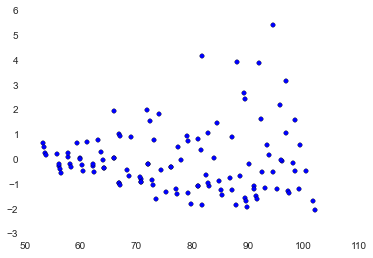

In [31]:
mod0 = pd.stats.ols.OLS(y=y_train, x=X_train.predicted_dist)
print mod0
plt.scatter(mod0.y_fitted, mod0.resid)

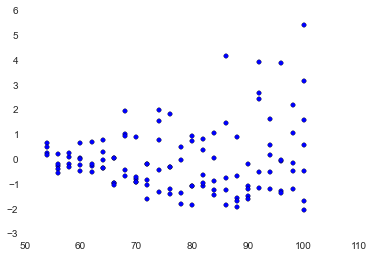

In [32]:
plt.scatter(y_train, mod0.resid)


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <predicted_dist> + <xmintimesxdiff> + <xdiff> + <xmin> + <xmin**2>
             + <xmin**4> + <intercept>

Number of Observations:         118
Number of Degrees of Freedom:   6

R-squared:         0.9993
Adj R-squared:     0.9993

Rmse:              0.3689

F-stat (6, 111): 27972.7333, p-value:     0.0000

Degrees of Freedom: model 6, resid 111

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
predicted_dist     1.2724     0.0262      48.58     0.0000     1.2211     1.3238
xmintimesxdiff     0.0000     0.0000      17.21     0.0000     0.0000     0.0000
         xdiff     0.0091     0.0012       7.61     0.0000     0.0068     0.0115
          xmin    -0.0473     0.0025     -19.15     0.0000    -0.0521 

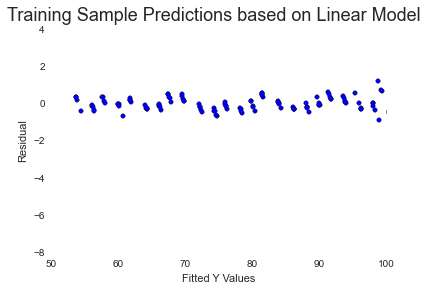

In [33]:
mod1 = pd.stats.ols.OLS(y=y_train, x=X_train[["predicted_dist", 'xmintimesxdiff', 'xdiff', "xmin", "xmin**2", "xmin**4"]])
#mod1 = pd.stats.ols.OLS(y=y_train, x=X_train[["predicted_dist", 'xmintimespredicted', 'xmintimespredicted**2']])
print mod1
fig=plt.figure()
fig2 = plt.scatter(mod1.y_fitted, mod1.resid)
fig2.axes.set_xlabel('Fitted Y Values')
fig2.axes.set_ylabel('Residual')
fig2.axes.set_ybound(lower=-8, upper=4)
fig2.axes.set_xbound(lower=50, upper=100)
fig.suptitle("Training Sample Predictions based on Linear Model", fontsize=18)


In [18]:
mod1


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <predicted_dist> + <xmintimesxdiff> + <xdiff> + <xmin> + <xmin**2>
             + <xmin**4> + <intercept>

Number of Observations:         118
Number of Degrees of Freedom:   6

R-squared:         0.9993
Adj R-squared:     0.9993

Rmse:              0.3690

F-stat (6, 111): 27959.3183, p-value:     0.0000

Degrees of Freedom: model 6, resid 111

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
predicted_dist     1.2744     0.0262      48.57     0.0000     1.2230     1.3258
xmintimesxdiff     0.0000     0.0000      17.21     0.0000     0.0000     0.0000
         xdiff     0.0094     0.0012       7.79     0.0000     0.0070     0.0118
          xmin    -0.0473     0.0025     -19.15     0.0000    -0.0521 

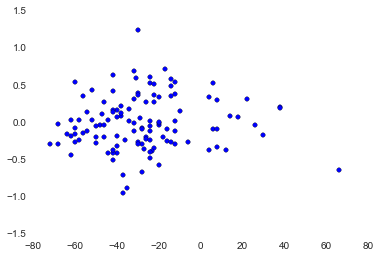

In [19]:
plt.scatter(X_train['ydiff'], mod1.resid)

In [16]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

In [39]:
mod1.beta[3]

-0.04726140971001247

In [38]:
print mse(y_train, mod0.y_fitted)
print mse(y_train, mod1.y_fitted)
print mae(y_train, mod0.y_fitted)
print mae(y_train, mod1.y_fitted)

1.79166258151
0.128004928034
0.984736398784
0.281953294825


In [250]:
y_test_pred = mod1.predict(x=X_test[["predicted_dist", 'xmintimesxdiff', 'xdiff', "xmin", "xmin**2", "xmin**4"]])
y_resid = y_test_pred - y_test

0.0970461354549
0.250453495078


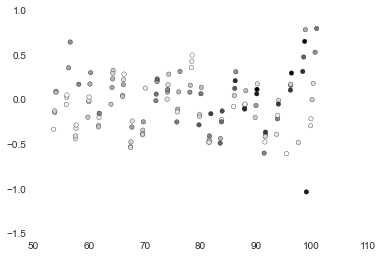

In [276]:
print mse(y_test_pred, y_test)
print mae(y_test_pred, y_test)
plt.scatter(y_test_pred, y_resid, c=X_test['xmin'])

In [78]:
## final function to take determine distance from camera to the pitch

def more_complex(X_pixels , y_pixels, pitcher_catcher_distance=60.5, s=0, h=0):
    """ s is number of feet in front of pitchers plate the camera is"""
    #pitchers_plate=x
    #home_plate=y

    #p_c_meters = pitcher_catcher_distance*0.3048
    #s_meters = s*0.3048
    #X_pixels = pitchers_plate[0] - home_plate[0]
    #y_pixels = pitchers_plate[1] - home_plate[1]
    X_proportion = abs(X_pixels / PIC_LENGTH)
    y_proportion = abs(y_pixels / PIC_HEIGHT)
    X_angle_degrees = X_proportion*FOVx
    X_angle_degrees_front = X_angle_degrees * (pitcher_catcher_distance - s) / pitcher_catcher_distance
    X_angle_radians_front = radians(X_angle_degrees_front)
    y_angle = radians(y_proportion*FOVy)
    distance_ft = (pitcher_catcher_distance-s) / tan(X_angle_radians_front)

    #distance_ft = distance_meters*(1/0.3048)

    # correct for h
    d = sqrt(distance_ft**2 - h**2)    
    
    return d

from math import  radians, sqrt, tan
# constants from the Iphone: FOV field of view in degrees, and number of pixels wide & tall in photo
FOVx=63.54
FOVy=44.95886879
PIC_LENGTH=3264.
PIC_HEIGHT=2448.

def dist_to_pitcher(p, c, pitcher_catcher_distance=60.5, h=5.):
    """
    p & c are tuples of 2 values-- the x-y coordinates of the pitcher and catcher respectively (Starting from top left corner)
    pitcher_catcher_distance is the distance (in reality) from the pitcher to the catcher in feet -- 60.5 for regulation baseball field
    h is the height off the ground that the pitcher holds the camera -- for our purposes we can assume 5 ft. on average(output not that sensitive)
    
    y coordinates are not used -- good predictions without
    """
    
    # I took empirical measurements from the right side of the pitcher if he is facing the catcher
    # so, if the picture is taken from the other side, we must switch the pitcher and catcher to represent this setup 
    # (this implicitly assumes the coefficients we estimated are true for both sides -- still need to verify)
    if p[0] > c[0]:
        p = (PIC_LENGTH - p[0], p[1])
        c = (PIC_LENGTH - c[0], c[1])
    
    # number of x pixels and y pixels between the pitcher and catcher
    x_pixels = abs(p[0] - c[0])
    
    # convert pixels to angle (in radians)
    x_proportion = x_pixels / PIC_LENGTH
    x_angle = radians(x_proportion*FOVx)
    
    # calculate distance with trig
    distance_ft = pitcher_catcher_distance / tan(x_angle)
    
    # this corrects for h -- right triangle: hypotenuse is distance_ft & h is "short side", we want "long side" that is on the ground
    d = sqrt(distance_ft**2 - h**2)
    
    ## d got us close to the correct distance when measured empirically, but not good enough, so we made a linear model of the
    ## difference between d and the real distance that was measured with a measuring tape
    
    ## that linear model takes as inputs:
    ##   d (calculated above)
    ##   x_pixels*p[0] the interaction
    ##   x_pixels
    ##   p[0] -- the x coordinate of the pitcher (this assumes that we are on the "right" hand side of the pitcher if he is looking at the catcher)
    ##   p[0]**2 the x coordinate of the pitcher squared
    ##   p[0]**4 the x coordinate of the pitcher to the 4th power
    ##   an intercept term
    
    # hard coded coefficients as estimated from a sample of photos
    coefficients = [1.2724175616337765, 
                    1.5722041791536374e-05,
                    0.0091480432806466325,
                    -0.04726140971001247,
                    1.2019398669013432e-05,
                    9.1210451413941492e-13,
                    -33.503517724311536
                   ]
    
    independent_vars = [d, x_pixels*p[0], x_pixels, p[0], p[0]**2, p[0]**4, 1]
    
    # dot product
    predicted_distance = sum(var*coef for var, coef in zip(independent_vars, coefficients))
    
    return predicted_distance
    

In [69]:
## test the final function
mod1.summary_as_matrix



,predicted_dist,xmintimesxdiff,xdiff,xmin,xmin**2,xmin**4,intercept
beta,1.272418e+00,1.572204e-05,9.148043e-03,-4.726141e-02,1.201940e-05,9.121045e-13,-3.350352e+01
p-value,1.246960e-76,4.085219e-33,9.663380e-12,5.576110e-37,4.873951e-17,3.765395e-03,2.841403e-12
std err,2.619046e-02,9.133644e-07,1.202195e-03,2.467333e-03,1.208956e-06,3.081760e-13,4.268381e+00
t-stat,4.858324e+01,1.721333e+01,7.609451e+00,-1.915486e+01,9.941964e+00,2.959687e+00,-7.849234e+00


In [79]:
X_dat = [((row.xmin, row.ymin), (row.xmax, row.ymax)) for index, row in X_test.iterrows()]
print X_dat[0]
preds = map(lambda sample: dist_to_pitcher(sample[0], sample[1], pitcher_catcher_distance=58.75), X_dat)
zip(preds, y_test)

((362, 1372), (2436, 1414))


[(69.44095819953766, 70),
 (75.6989099030313, 76),
 (87.77346200600887, 88),
 (91.35972092648753, 92),
 (53.80223635040613, 54),
 (57.40696680512322, 58),
 (63.995048674851816, 64),
 (73.9619617686418, 74),
 (57.28874211265811, 58),
 (59.718165210112886, 60),
 (65.99234526777559, 66),
 (61.58474106963932, 62),
 (57.901157230828716, 58),
 (81.33790807949885, 82),
 (65.93889534713942, 66),
 (96.14842589231463, 96),
 (79.95356548083285, 80),
 (71.85544899809972, 72),
 (61.54740125639337, 62),
 (96.0104113894966, 96),
 (73.88609559632368, 74),
 (61.597254586797376, 62),
 (56.07749514819572, 56),
 (69.4010670997754, 70),
 (59.5446744453474, 60),
 (75.8927498660334, 76),
 (79.88482986678595, 80),
 (64.09024368937311, 64),
 (100.38690937182241, 100),
 (60.04522488931272, 60),
 (79.53534316063885, 80),
 (65.81812200000098, 66),
 (89.63593532130982, 90),
 (93.83417715361132, 94),
 (69.5374217612418, 70),
 (91.44779974168037, 92),
 (83.34003256707813, 84),
 (69.91059112399664, 70),
 (86.14489861

In [62]:
for x in X_test.iterrows():
    print x

(160, photo_no                                     193
direction                                   down
xmin                                         362
ymin                                        1372
xmax                                        2436
ymax                                        1414
xdiff                                       2074
logxdiff                                7.637234
ydiff                                        -42
xmintimesxdiff                            750788
xmin**2                                   131044
xmin**3                                 47437928
xmin**4                              17172529936
xmin**6                         2250357012933184
logxmin                                 5.891644
predicted_dist                           69.0936
xmintimesxdifftimespredicted        5.187465e+07
xmintimespredicted                      25011.88
xmintimespredicted**2               6.255943e+08
xmintimespredicted**4               3.913683e+17
predicted_dist

In [64]:
X_test.iterrows()[0]


TypeError: 'generator' object has no attribute '__getitem__'